# kernel_scan Quick Start

This notebook demonstrates how to use the kernel_scan library to profile GEMM operations and analyze performance with roofline models.

In [1]:
import sys
from pathlib import Path

# Add the src directory to sys.path to import kernel_scan
# Note: This is only needed when running from the repository
project_root = Path.cwd().parent.parent.parent
src_path = project_root / "src"
sys.path.append(str(src_path))

from kernel_scan.core.logging import configure_logging, get_logger
from kernel_scan.api.operations.gemm import GemmScan, GemmPlotter
from kernel_scan.core.types import DataType, EngineType

import polars as pl

# Configure logging with desired level
configure_logging(level="debug")
log = get_logger("quickstart")

## Configure and Run a GEMM Scan

We'll configure a simple GEMM scan with:
- Data Type: FLOAT16
- M values: 1, 2
- N values: 64, 128
- K = N for all test cases

In [2]:
# Initialize the GemmScan object with default parameters
scan = GemmScan()

# Configure and run the scan using the fluent API
results = (
    scan
    .with_data_types([ DataType.FLOAT16, DataType.FLOAT32, DataType.INT8])
    .with_engine_type(EngineType.COMPOSABLE_KERNEL)
    #.for_n_values([2**n for n in range(2, 6)])  # powers of 2 from 2⁶ to 2¹⁴
    #.for_m_values([2**n for n in range(0, 4)])  # powers of 2 from 2⁰ to 2⁸
    .for_n_values([2**n for n in range(6, 15)])  # powers of 2 from 2⁶ to 2¹⁴
    .for_m_values([2**n for n in range(0, 9)])  # powers of 2 from 2⁰ to 2⁸
    .with_k_equals_n()  # Configure the scan to use K = N for all test cases
    .iterations(10)
    .warmup(5)
    .run()
)

2025-06-26 18:29:06,924 - kernel_scan.gemm - INFO - Creating output directory: results/gemm_composable_kernel_20250626_182906
2025-06-26 18:29:06,925 - kernel_scan.gemm - INFO - Generated 243 test cases
2025-06-26 18:29:06,925 - kernel_scan.gemm - INFO - Starting GEMM performance scan...
2025-06-26 18:29:06,925 - kernel_scan.gemm - INFO - Data types: ['FLOAT16', 'FLOAT32', 'INT8']
2025-06-26 18:29:06,925 - kernel_scan.gemm - INFO - M values: [1, 2, 4, 8, 16, 32, 64, 128, 256]
2025-06-26 18:29:06,925 - kernel_scan.gemm - INFO - N values: [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
2025-06-26 18:29:06,926 - kernel_scan.gemm - INFO - K values: Same as N
2025-06-26 18:29:06,926 - kernel_scan.gemm - INFO - Output directory: results/gemm_composable_kernel_20250626_182906
2025-06-26 18:29:06,926 - kernel_scan.gemm - WARNING - Output directory does not exist, creating it now: results/gemm_composable_kernel_20250626_182906/FLOAT16/NK64
2025-06-26 18:29:06,927 - kernel_scan.gemm - INFO - 

## Generate Roofline Plots

Now we'll use the new GemmPlotter class to generate roofline plots for our results.

In [3]:
result_sets = []
for data_type, result_sets in results.items():
    print(data_type, len(result_sets))
    result_sets += result_sets

FLOAT16 81
FLOAT32 81
INT8 81


In [4]:
len(result_sets)

162

In [5]:
dfs = [rs.results_as_dataframe for rs in result_sets] 

In [6]:
combined = pl.concat(dfs)

In [7]:
display(combined)

shape: (8_064, 7)
┌─────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ is_best ┆ latency_valu ┆ latency_unit ┆ memory_bandw ┆ memory_bandw ┆ compute_perf ┆ compute_per │
│ ---     ┆ e            ┆ ---          ┆ idth_value   ┆ idth_unit    ┆ ormance_valu ┆ formance_un │
│ bool    ┆ ---          ┆ str          ┆ ---          ┆ ---          ┆ e            ┆ it          │
│         ┆ f64          ┆              ┆ f64          ┆ str          ┆ ---          ┆ ---         │
│         ┆              ┆              ┆              ┆              ┆ f64          ┆ str         │
╞═════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ false   ┆ 21.6872      ┆ μs           ┆ 0.19477      ┆ GB/s         ┆ 0.377735     ┆ GFLOP/s     │
│ false   ┆ 21.4047      ┆ μs           ┆ 0.197339     ┆ GB/s         ┆ 0.382719     ┆ GFLOP/s     │
│ false   ┆ 20.8623      ┆ μs           ┆ 0.20247      ┆ GB/s         ┆ 0.392669     ┆ GFLOP/s     │
│ false   ┆ 13.6946      ┆ μs           ┆ 0.308442     ┆ GB/s         ┆ 0.598191     ┆ GFLOP/s     │
│ false   ┆ 9.85216      ┆ μs           ┆ 0.428738     ┆ GB/s         ┆ 0.831493     ┆ GFLOP/s     │
│ …       ┆ …            ┆ …            ┆ …            ┆ …            ┆ …            ┆ …           │
│ false   ┆ 2228.65      ┆ μs           ┆ 124.212      ┆ GB/s         ┆ 61669.2      ┆ GFLOP/s     │
│ false   ┆ 21229.9      ┆ μs           ┆ 13.0394      ┆ GB/s         ┆ 6473.85      ┆ GFLOP/s     │
│ false   ┆ 33223.0      ┆ μs           ┆ 8.3323       ┆ GB/s         ┆ 4136.86      ┆ GFLOP/s     │
│ false   ┆ 1876.64      ┆ μs           ┆ 147.511      ┆ GB/s         ┆ 73236.9      ┆ GFLOP/s     │
│ true    ┆ 1783.33      ┆ μs           ┆ 155.229      ┆ GB/s         ┆ 77068.8      ┆ GFLOP/s     │
└─────────┴──────────────┴──────────────┴──────────────┴──────────────┴──────────────┴─────────────┘

In [8]:
roofline_data_list = []
for rs in result_sets:
    rf_df = GemmPlotter.calculate_roofline_data(rs)
    roofline_data_list.append(rf_df)

In [9]:
roofline_combined = pl.concat(roofline_data_list)

In [10]:
(
    roofline_combined
    .unique(pl.col("m"))
    .sort(pl.col("m"))
    .select("m")
)

shape: (9, 1)
┌─────┐
│ m   │
│ --- │
│ i32 │
╞═════╡
│ 1   │
│ 2   │
│ 4   │
│ 8   │
│ 16  │
│ 32  │
│ 64  │
│ 128 │
│ 256 │
└─────┘

In [11]:
# Use the GemmPlotter class to generate plots
figures = []
for data_type, result_sets in results.items():
    plots_by_m = GemmPlotter.generate_roofline_plots_by_group(result_sets, "m")
    figures.append(plots_by_m)

2025-06-26 19:02:20,452 - kernel_scan.gemm - WARNING - No results in result_set
2025-06-26 19:02:20,452 - kernel_scan.core.plots - WARNING - Group column 'm' not found in result, skipping
2025-06-26 19:02:20,452 - kernel_scan.gemm - WARNING - No results in result_set
2025-06-26 19:02:20,453 - kernel_scan.core.plots - WARNING - Group column 'm' not found in result, skipping
2025-06-26 19:02:20,453 - kernel_scan.gemm - WARNING - No results in result_set
2025-06-26 19:02:20,453 - kernel_scan.core.plots - WARNING - Group column 'm' not found in result, skipping
2025-06-26 19:02:20,453 - kernel_scan.gemm - WARNING - No results in result_set
2025-06-26 19:02:20,453 - kernel_scan.core.plots - WARNING - Group column 'm' not found in result, skipping
2025-06-26 19:02:20,453 - kernel_scan.gemm - WARNING - No results in result_set
2025-06-26 19:02:20,454 - kernel_scan.core.plots - WARNING - Group column 'm' not found in result, skipping
2025-06-26 19:02:20,454 - kernel_scan.gemm - WARNING - No re

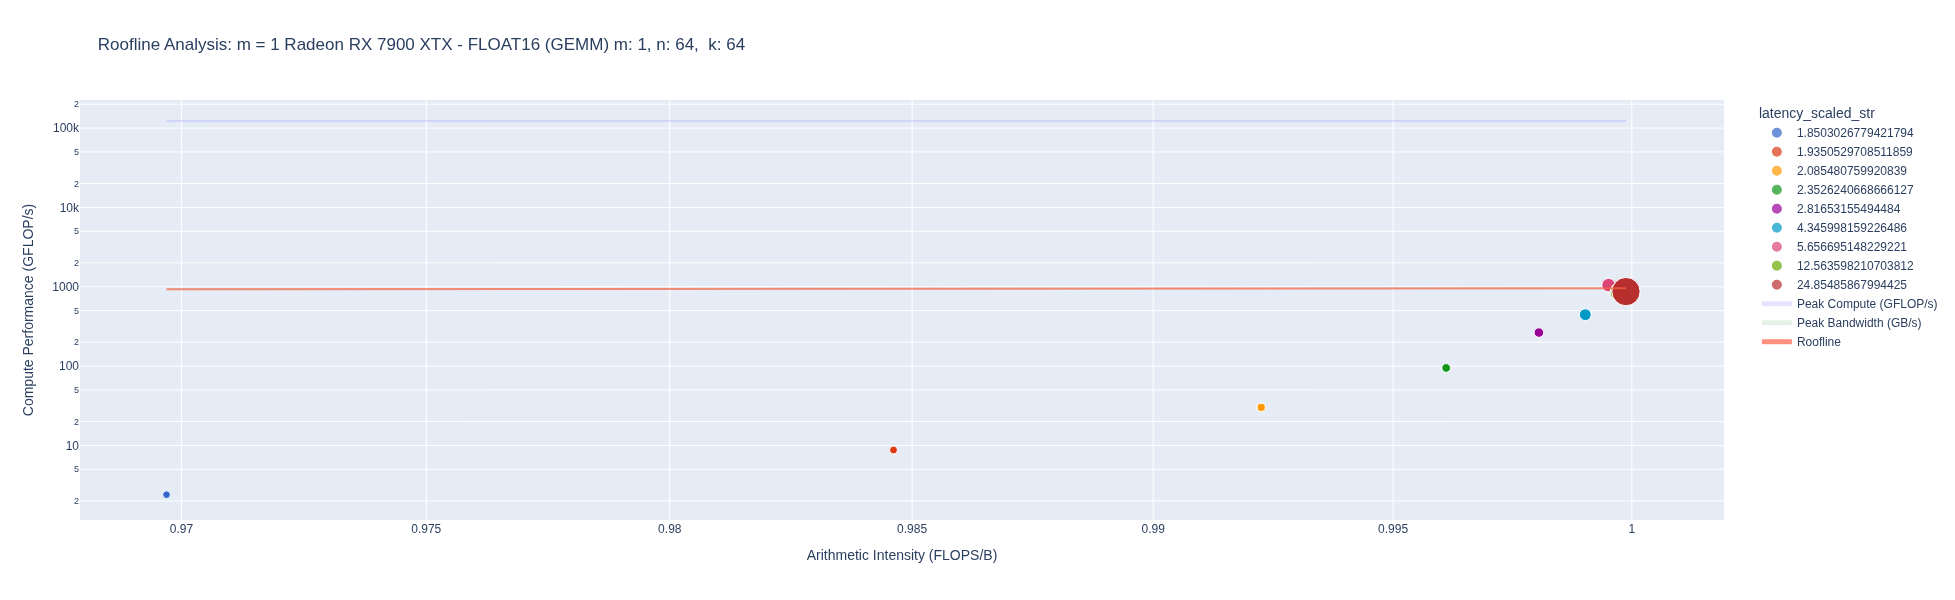

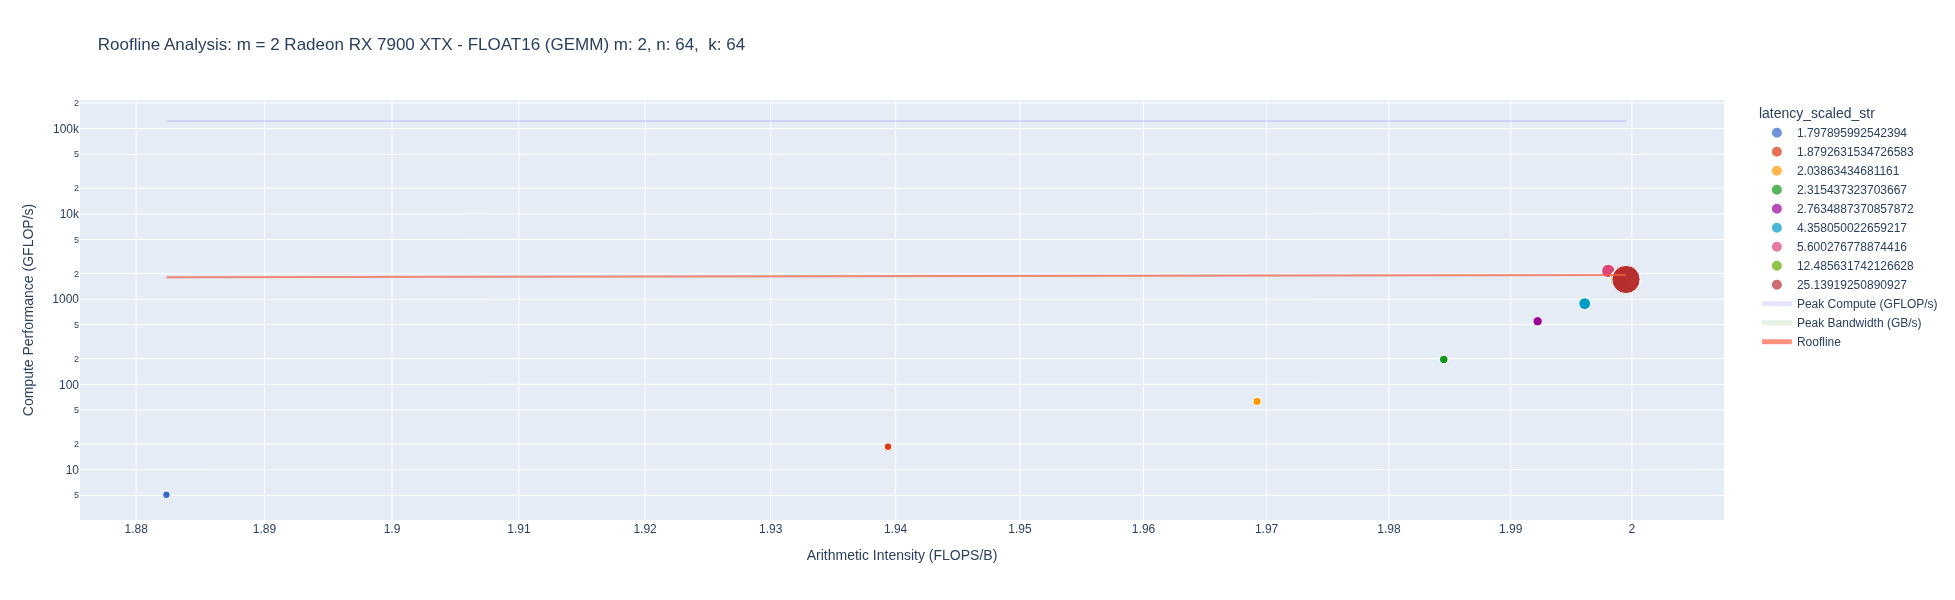

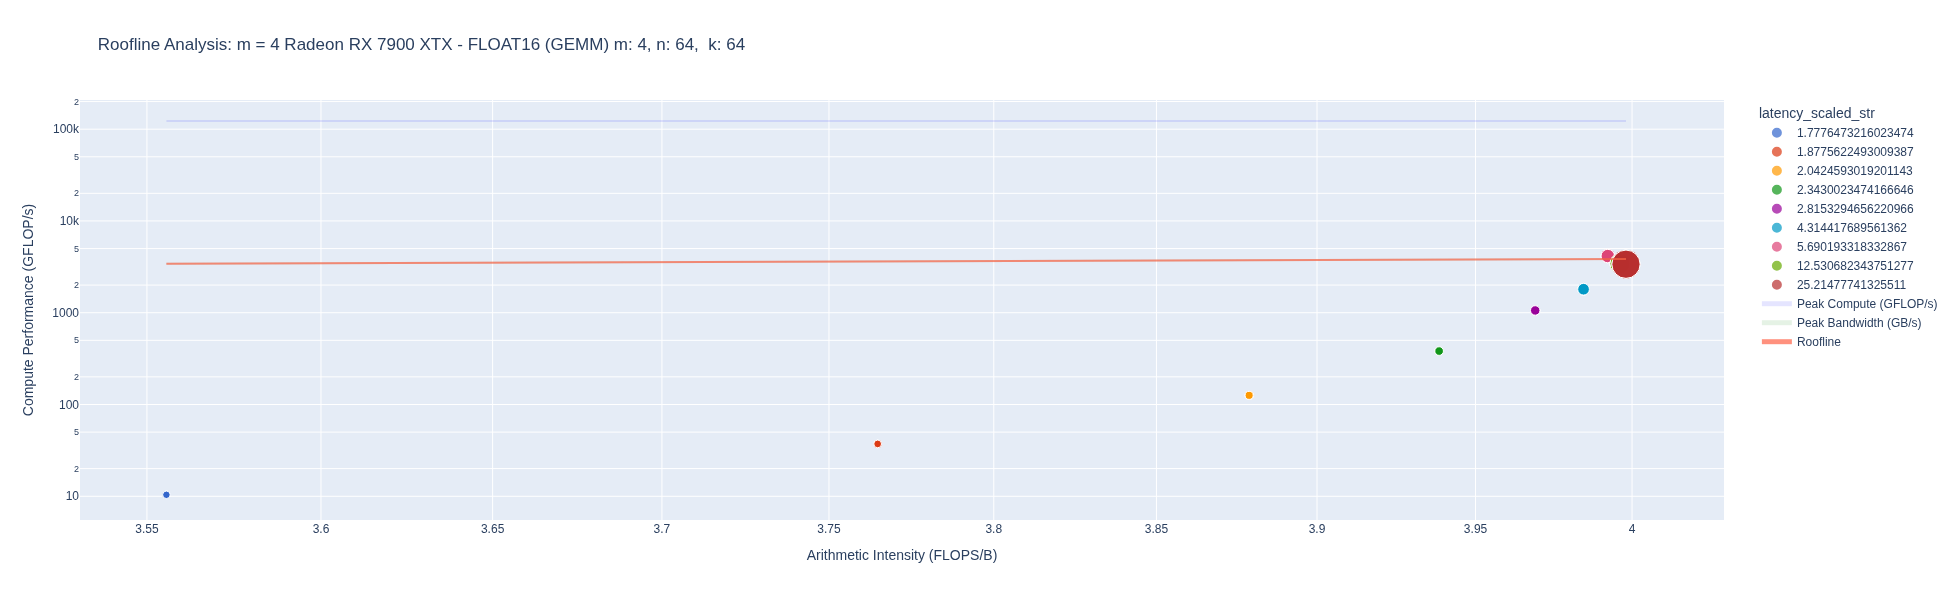

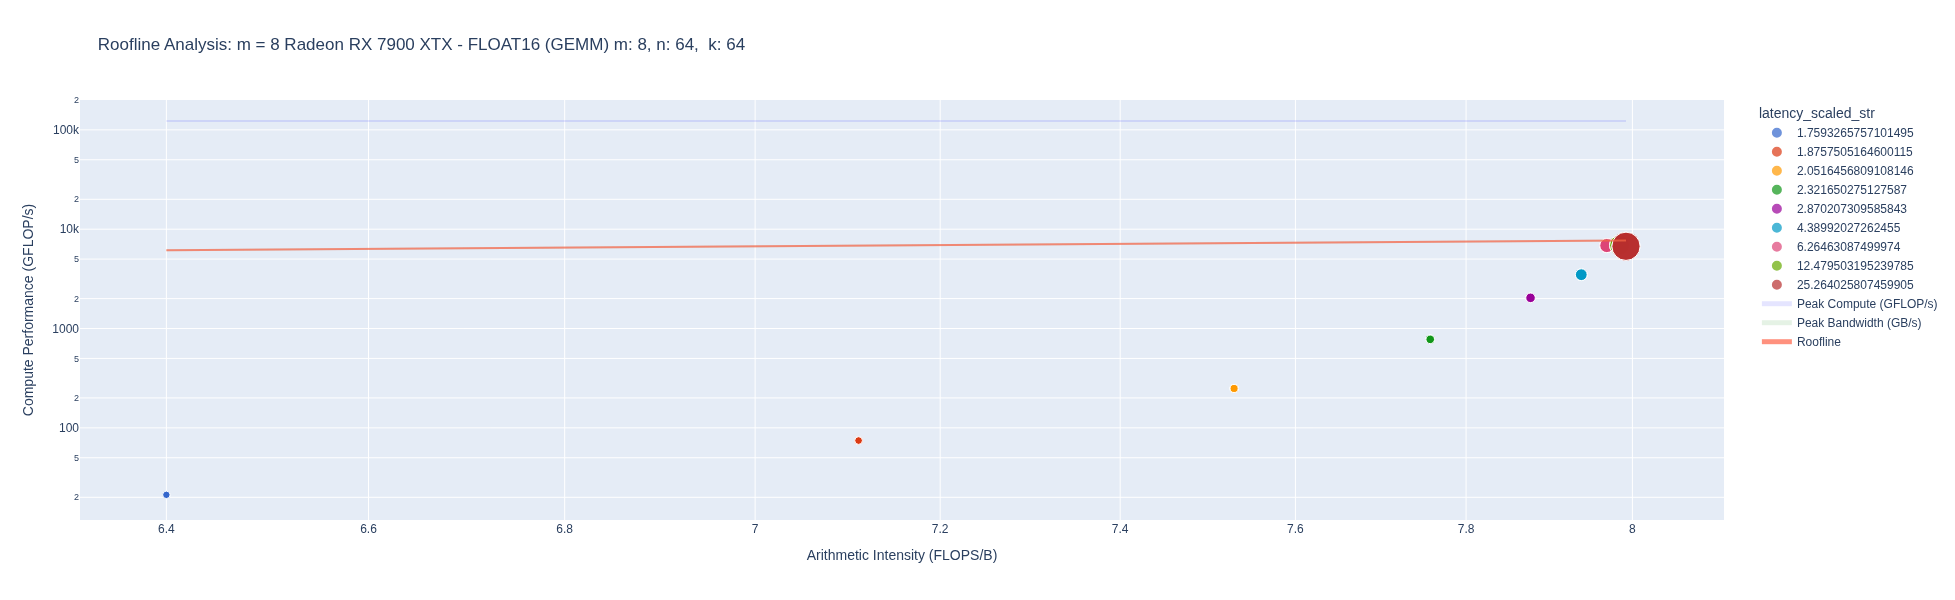

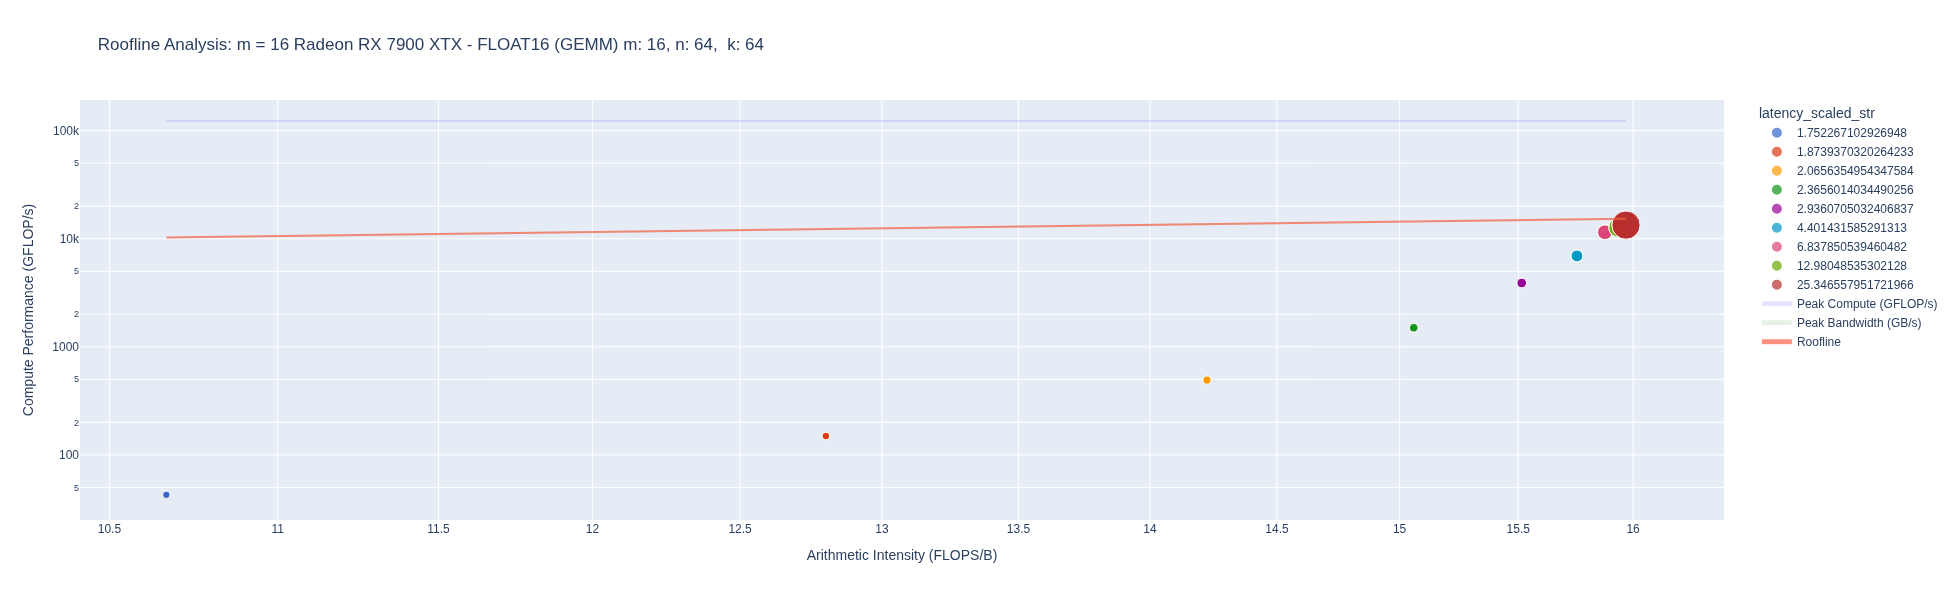

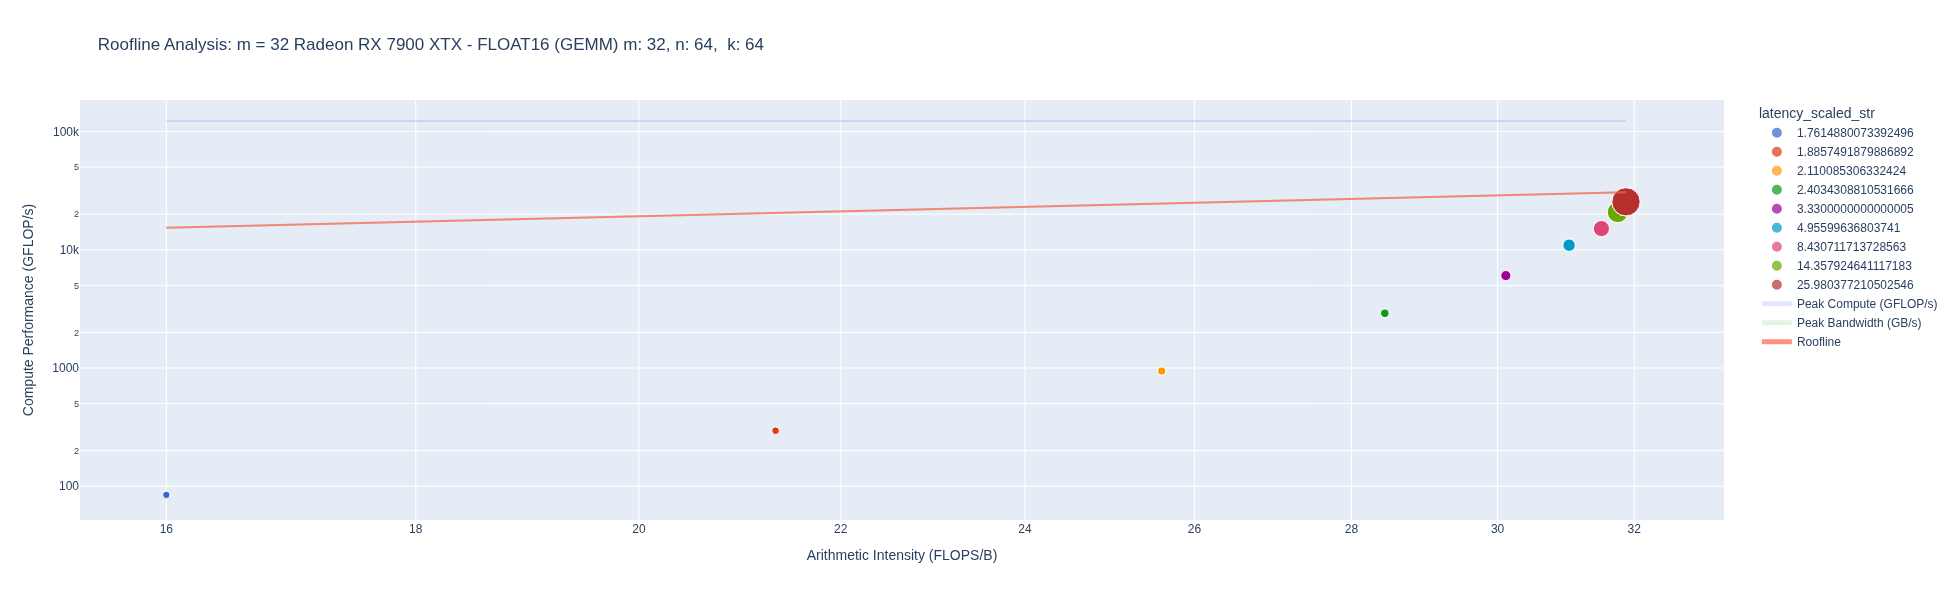

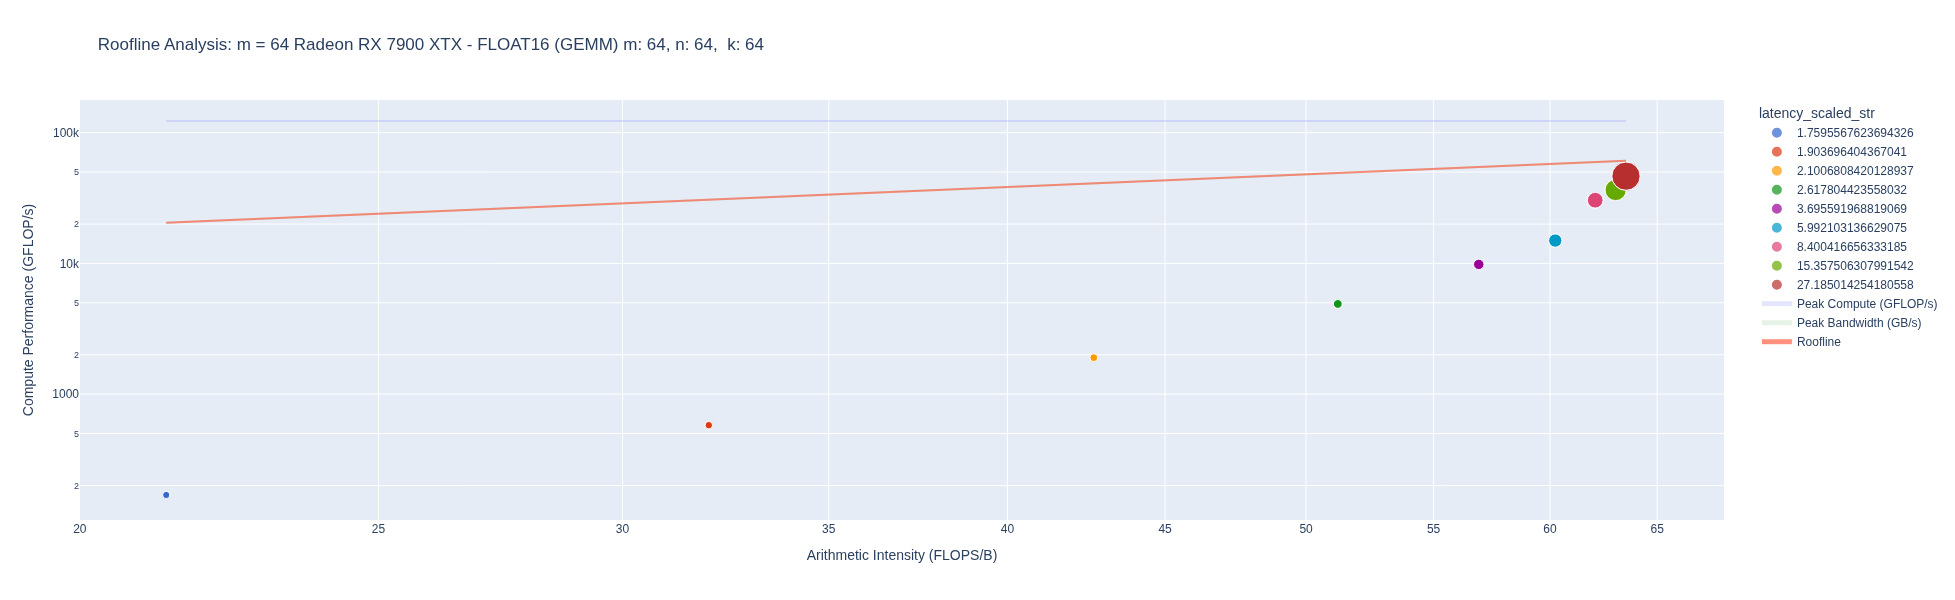

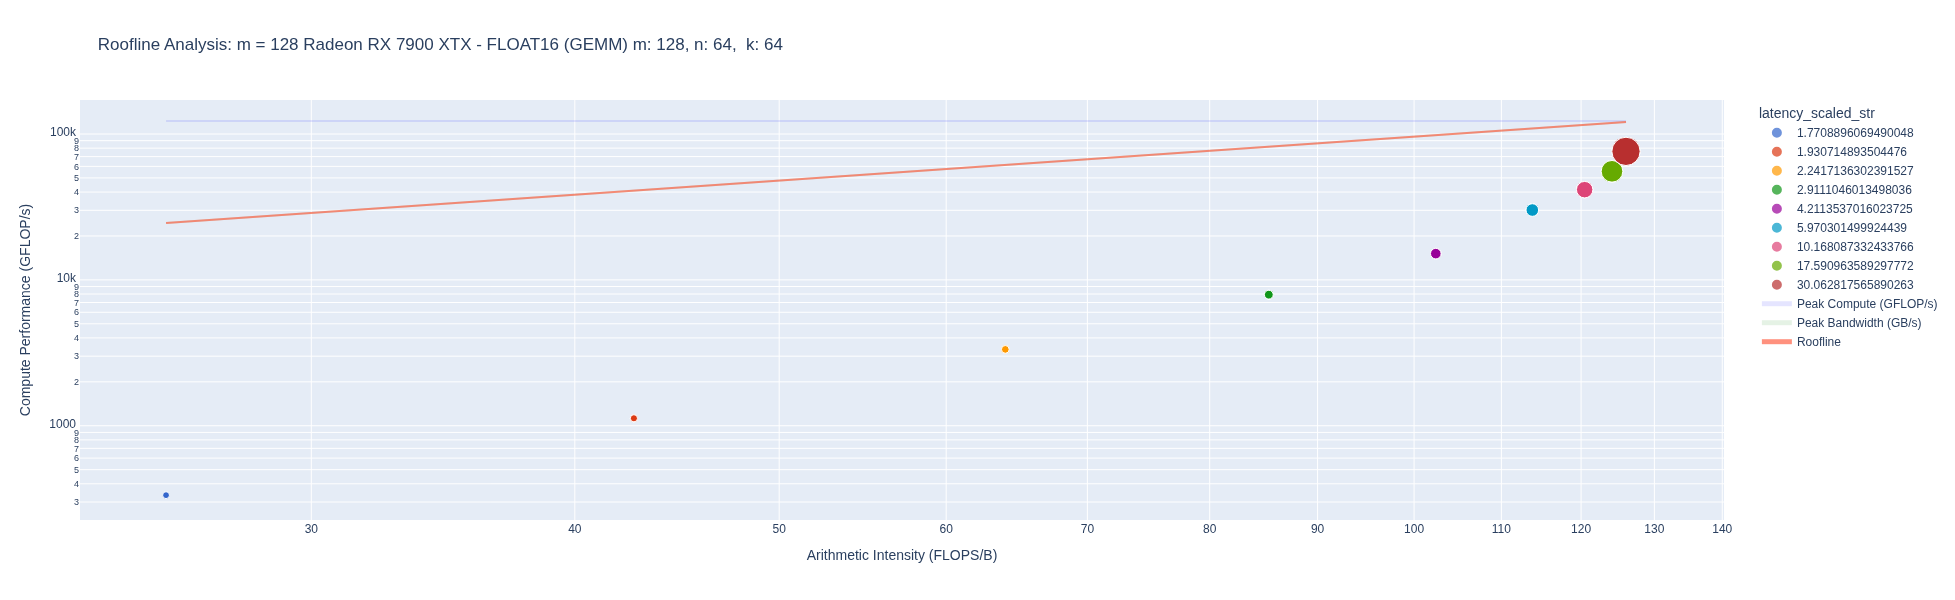

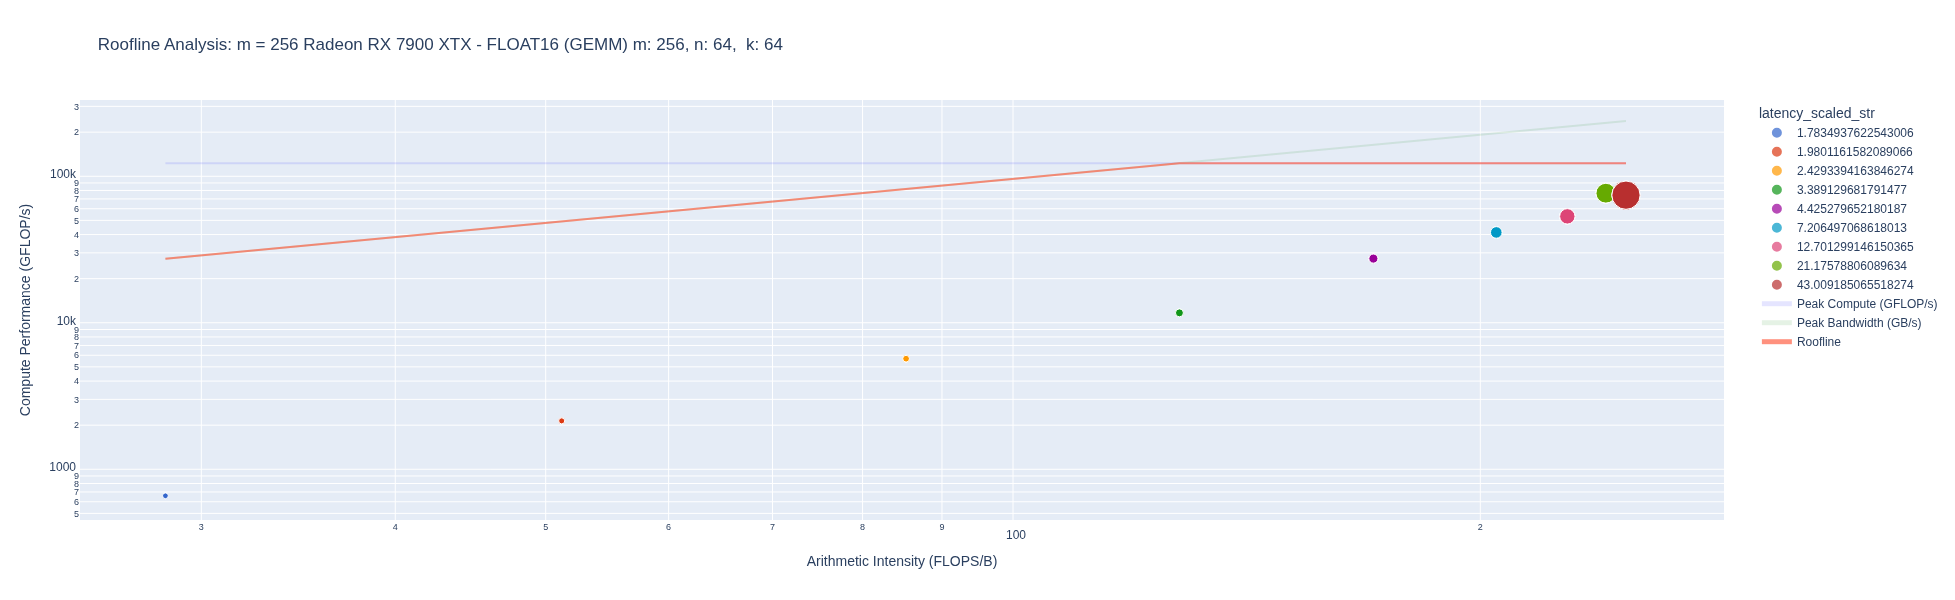

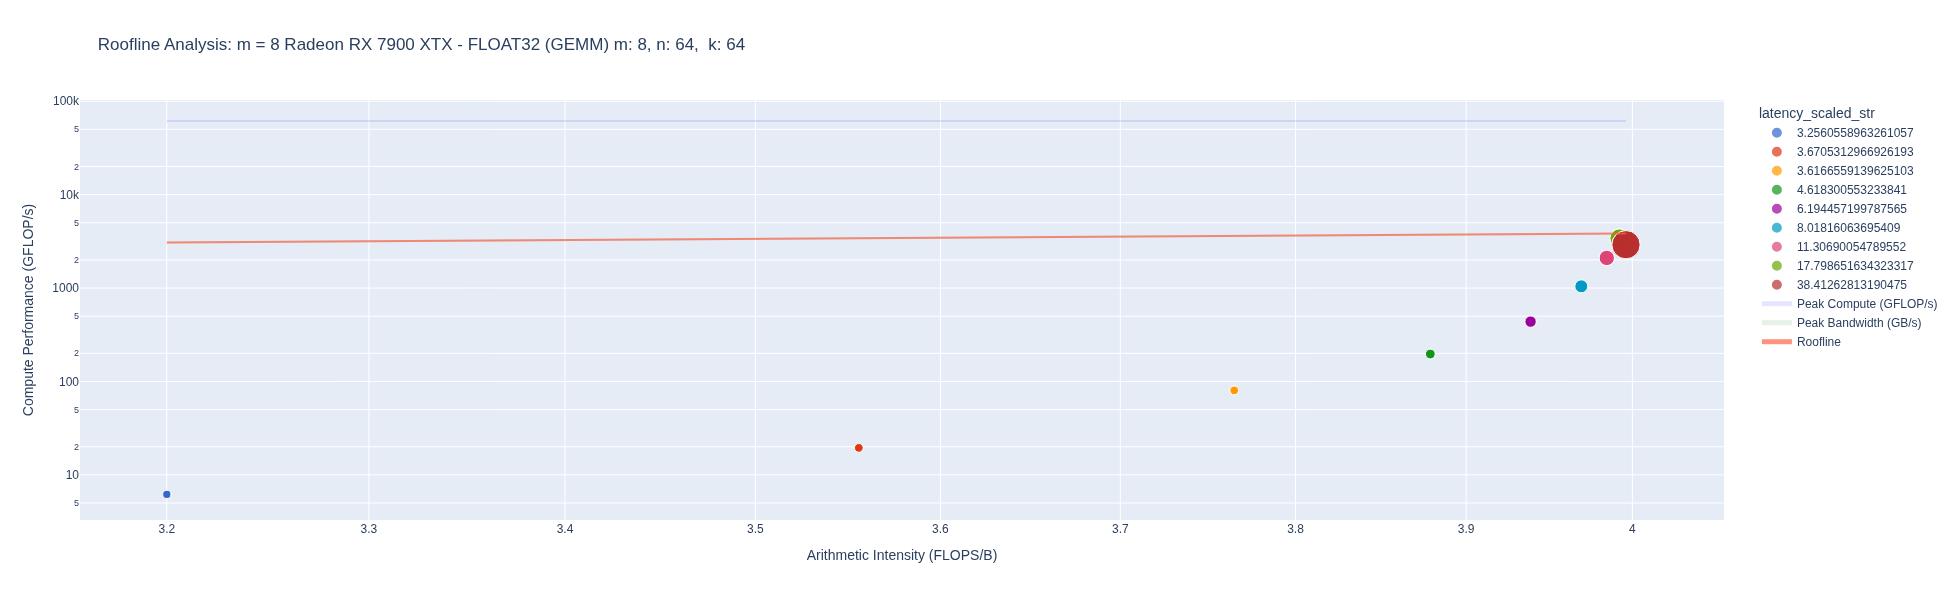

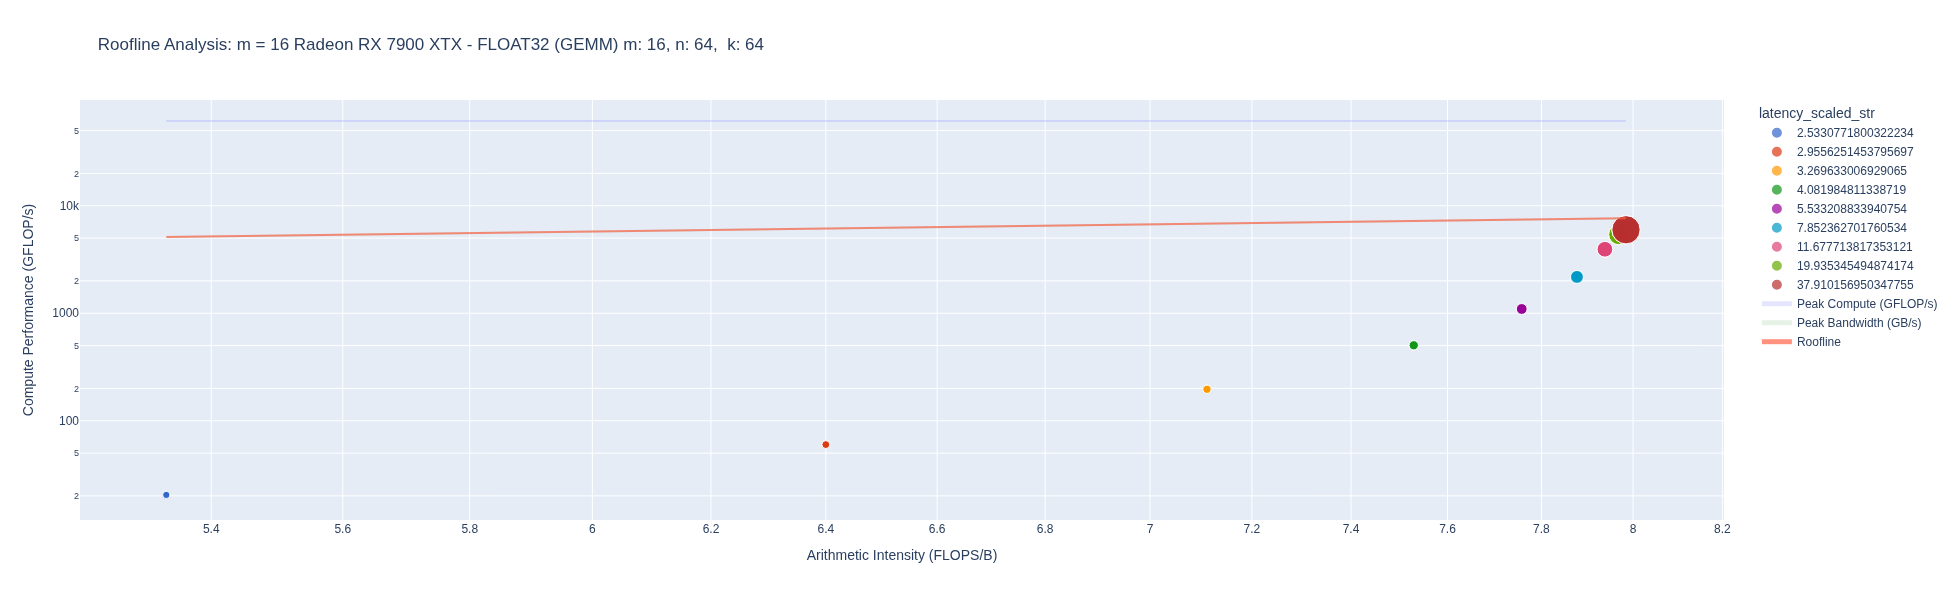

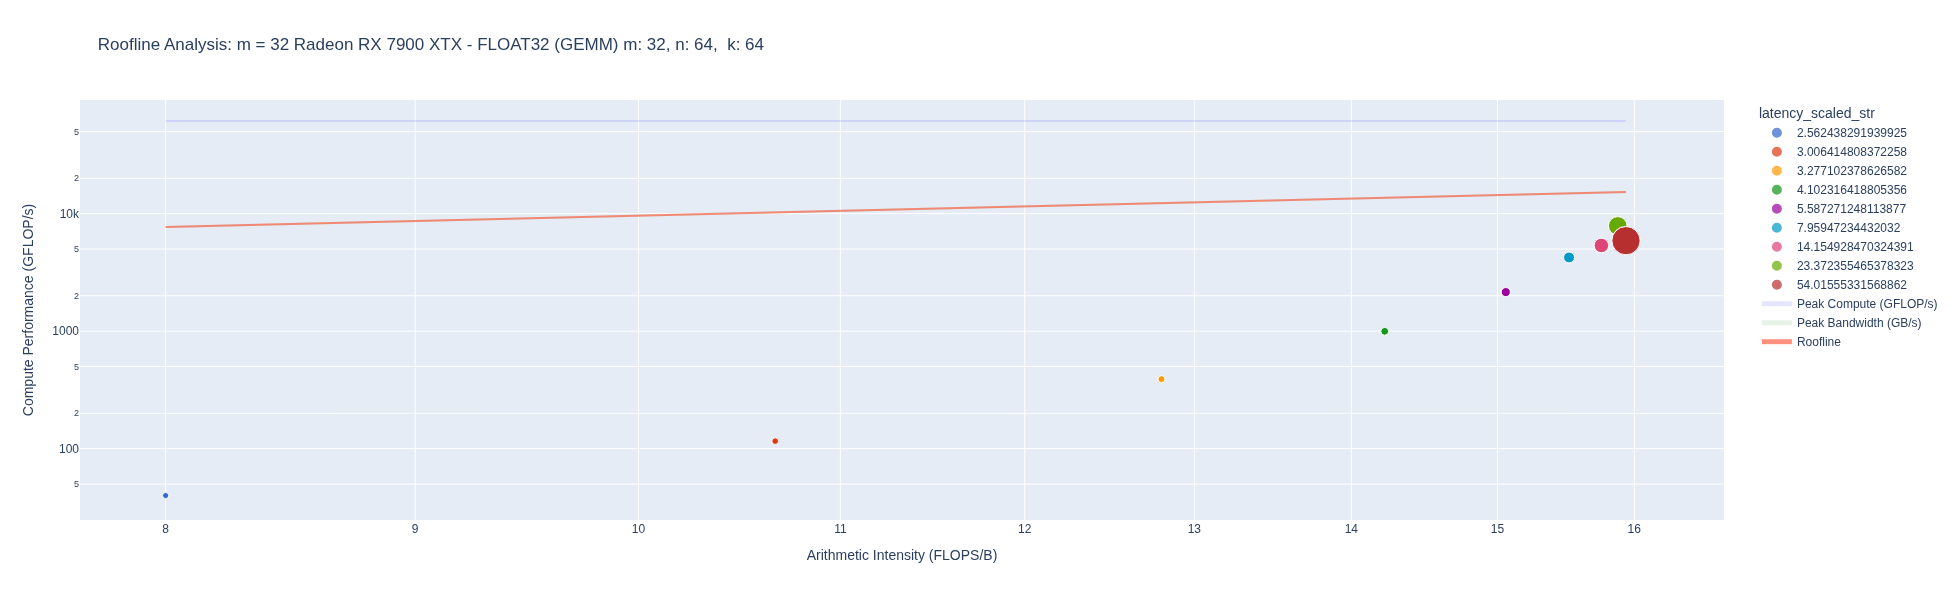

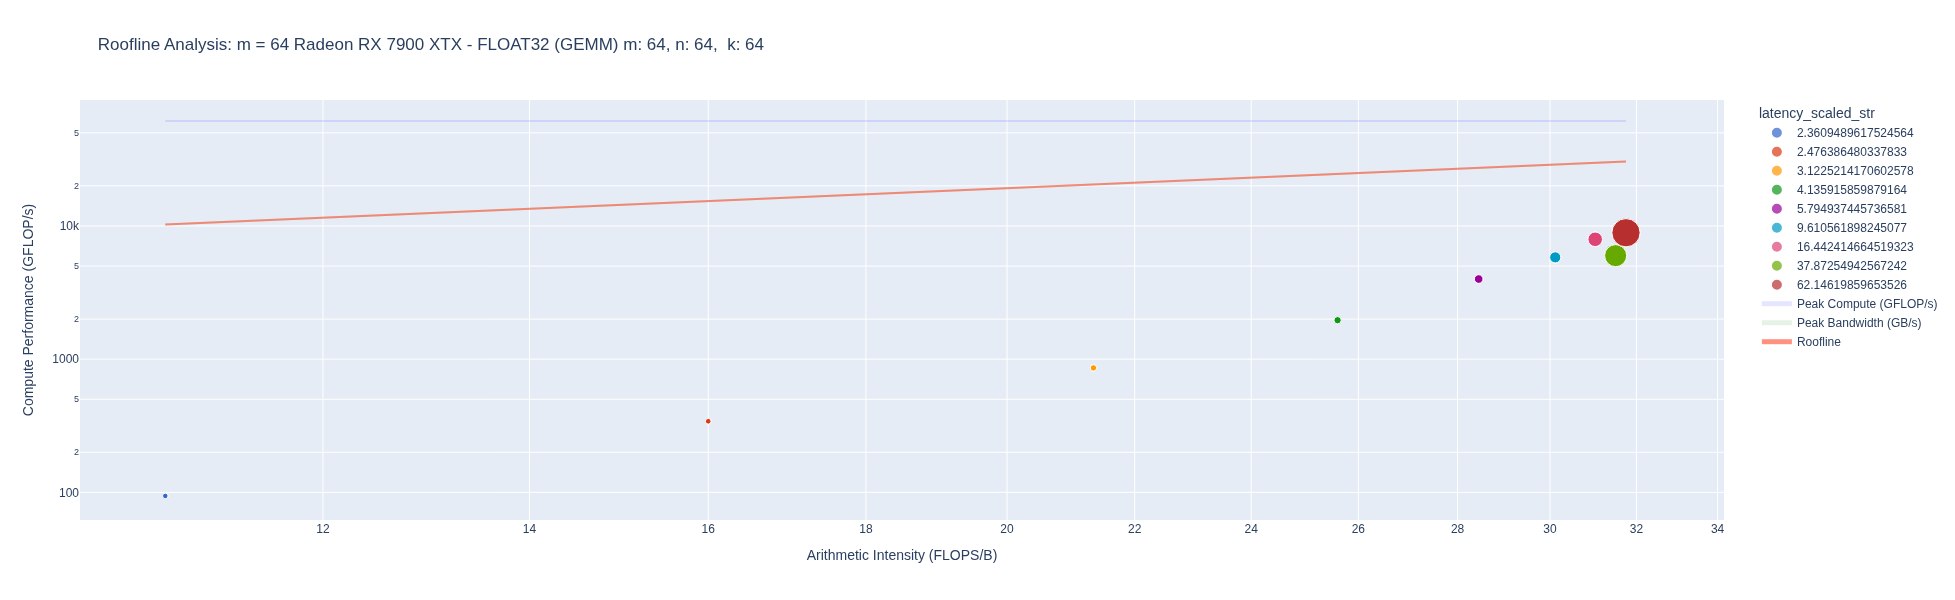

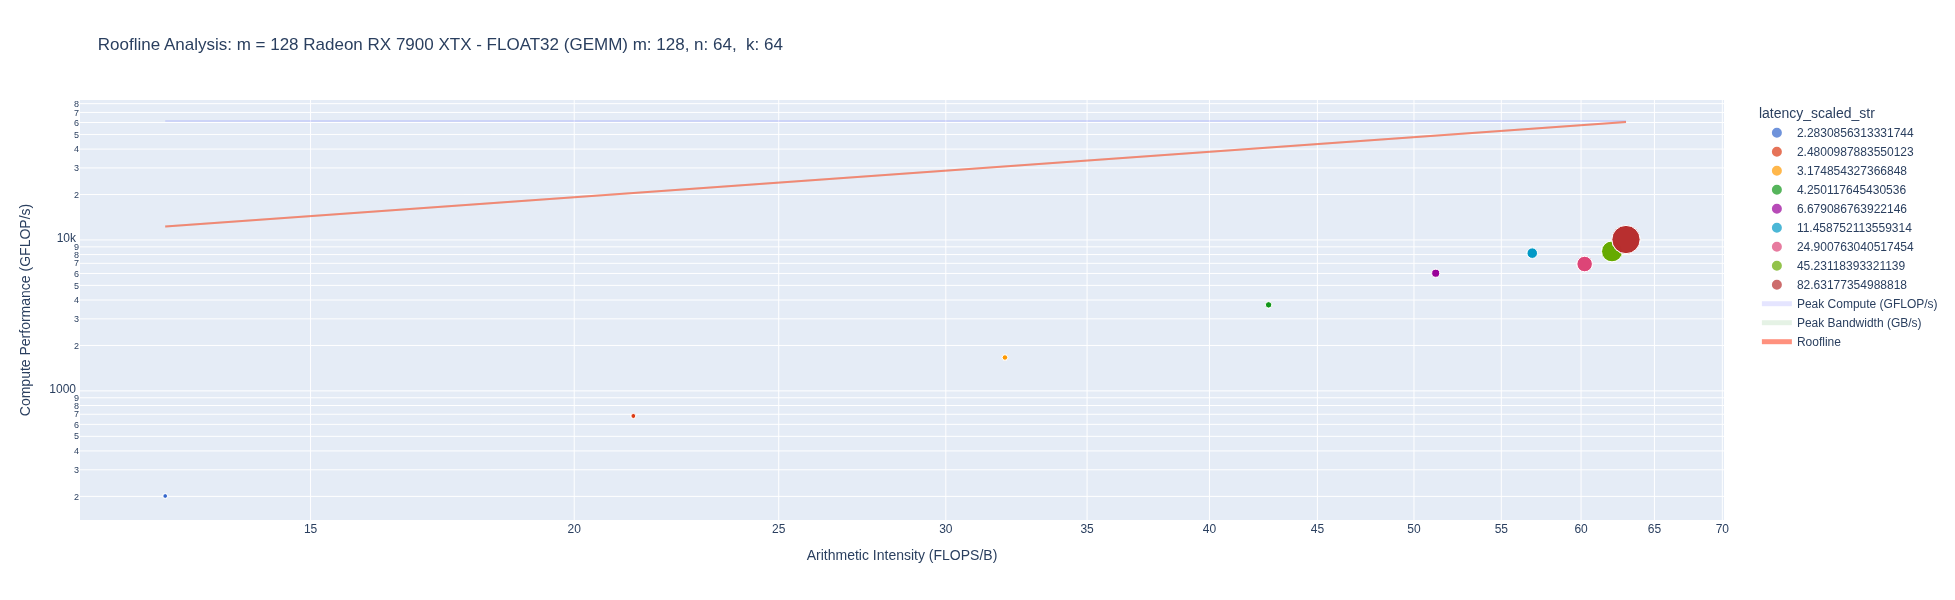

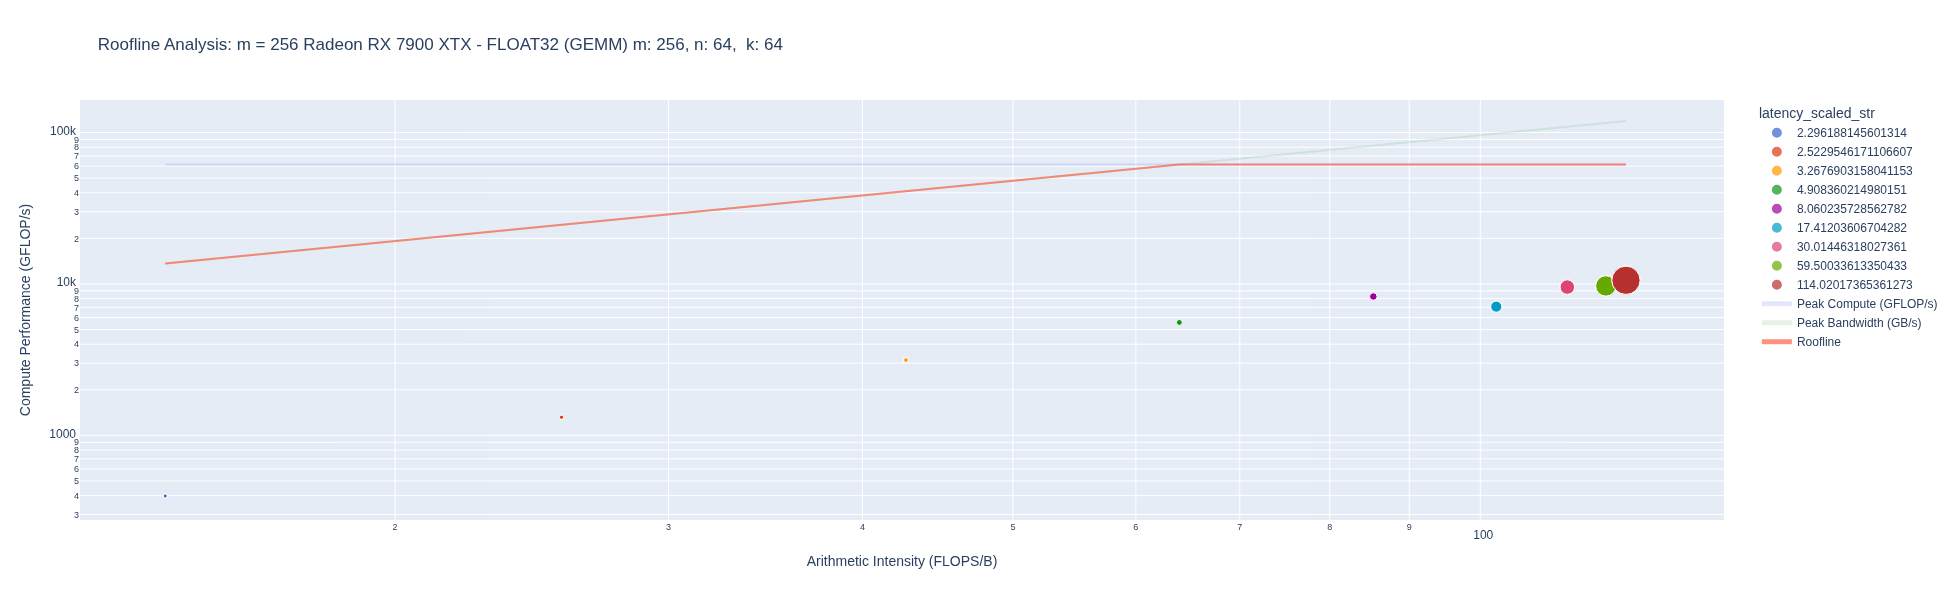

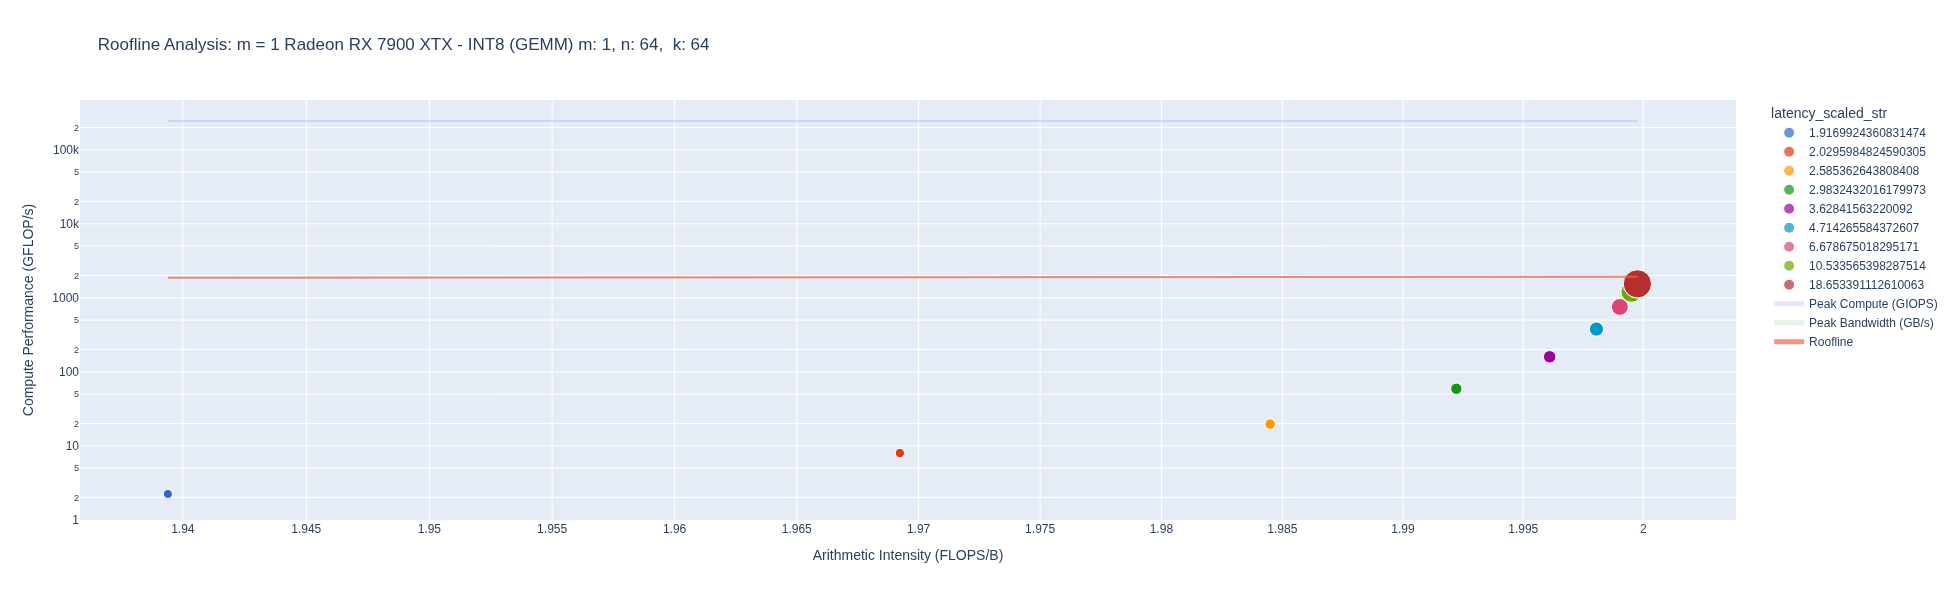

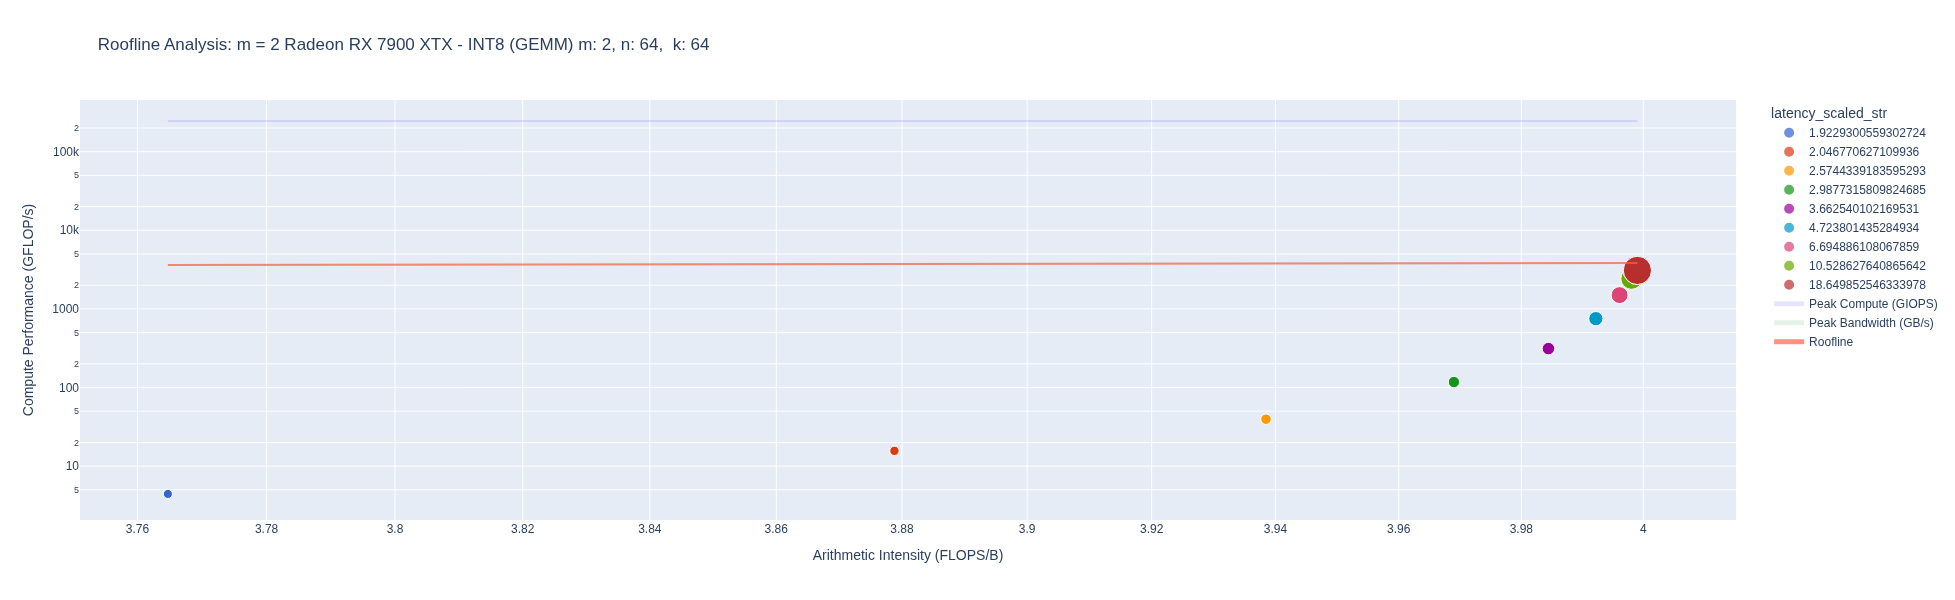

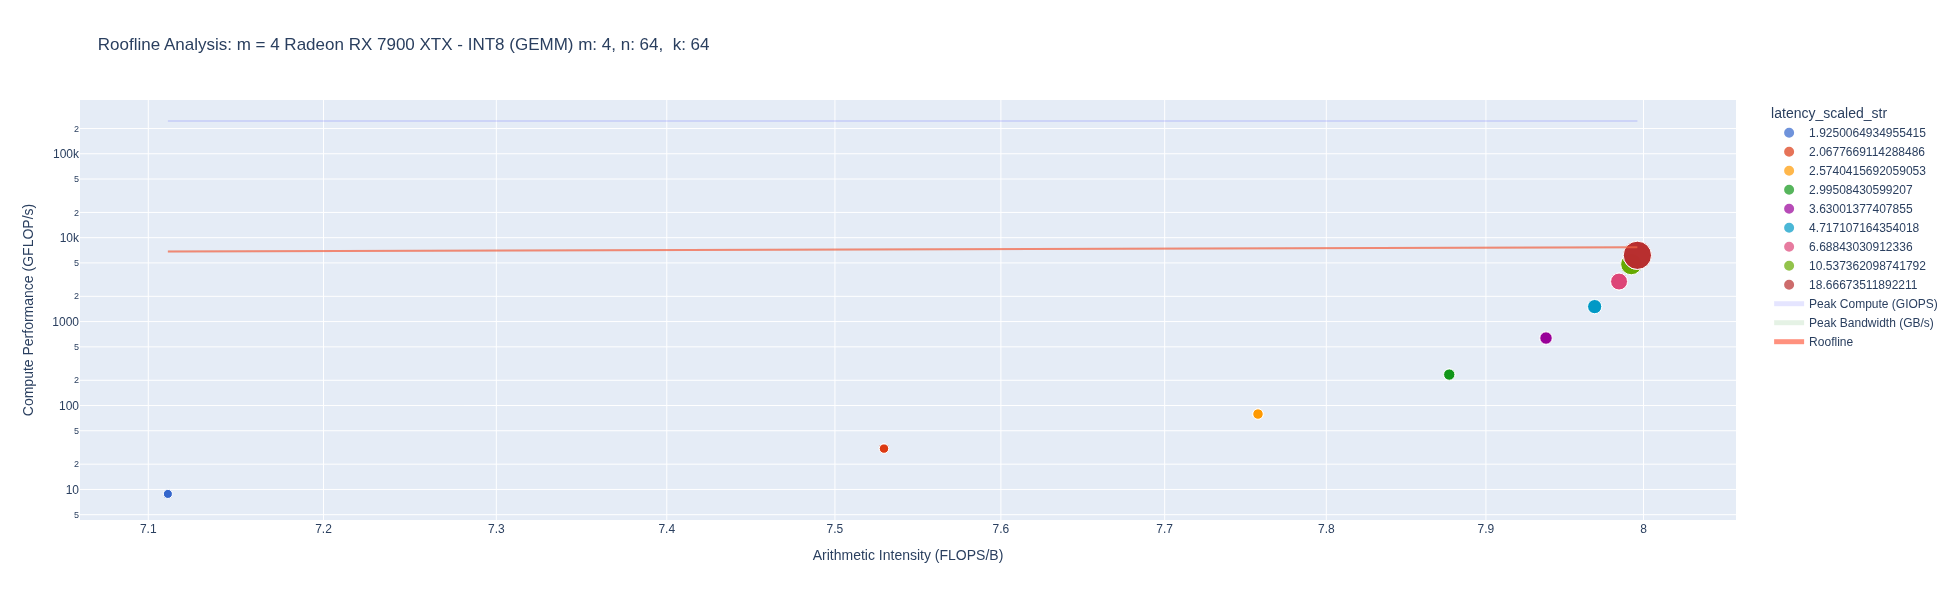

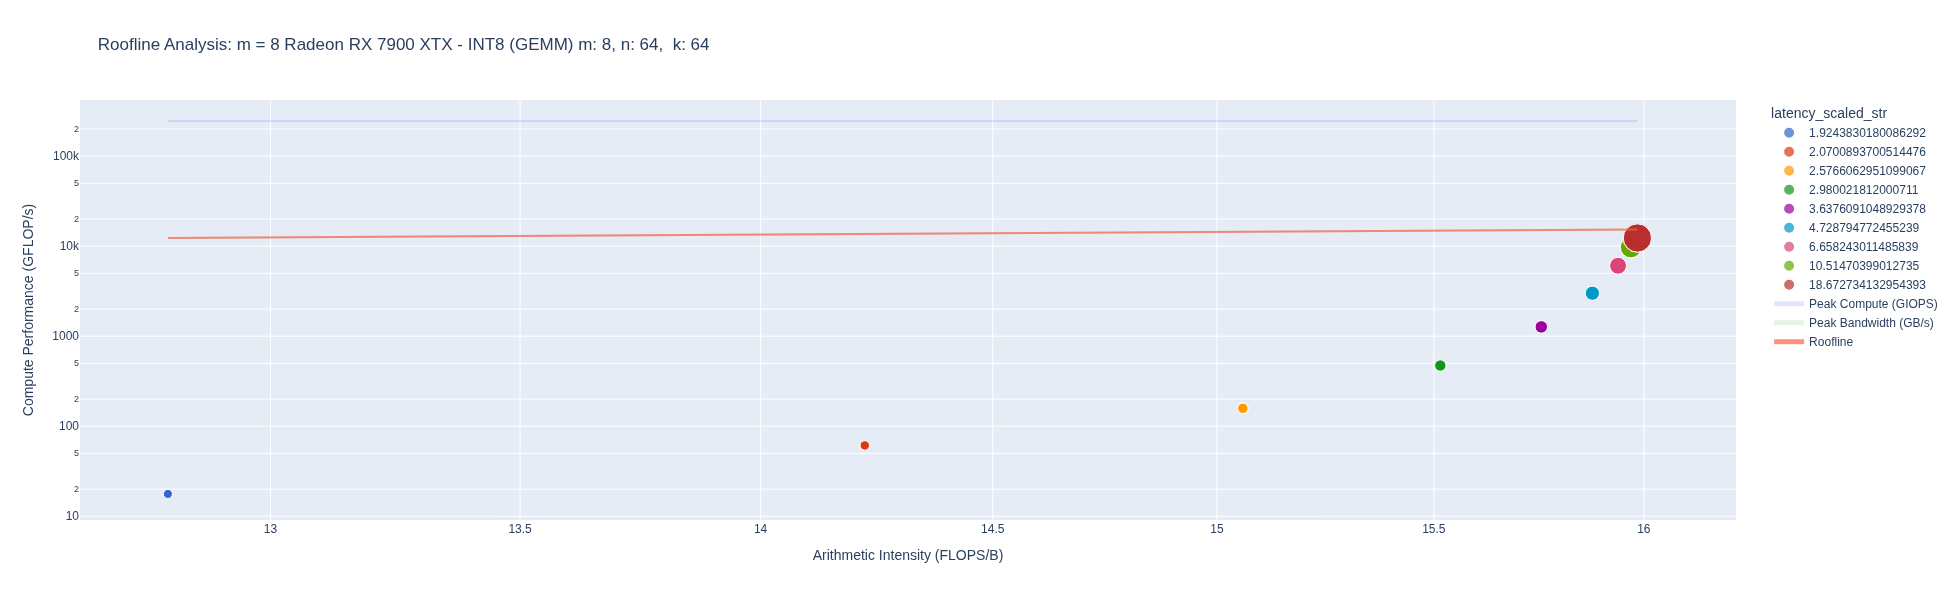

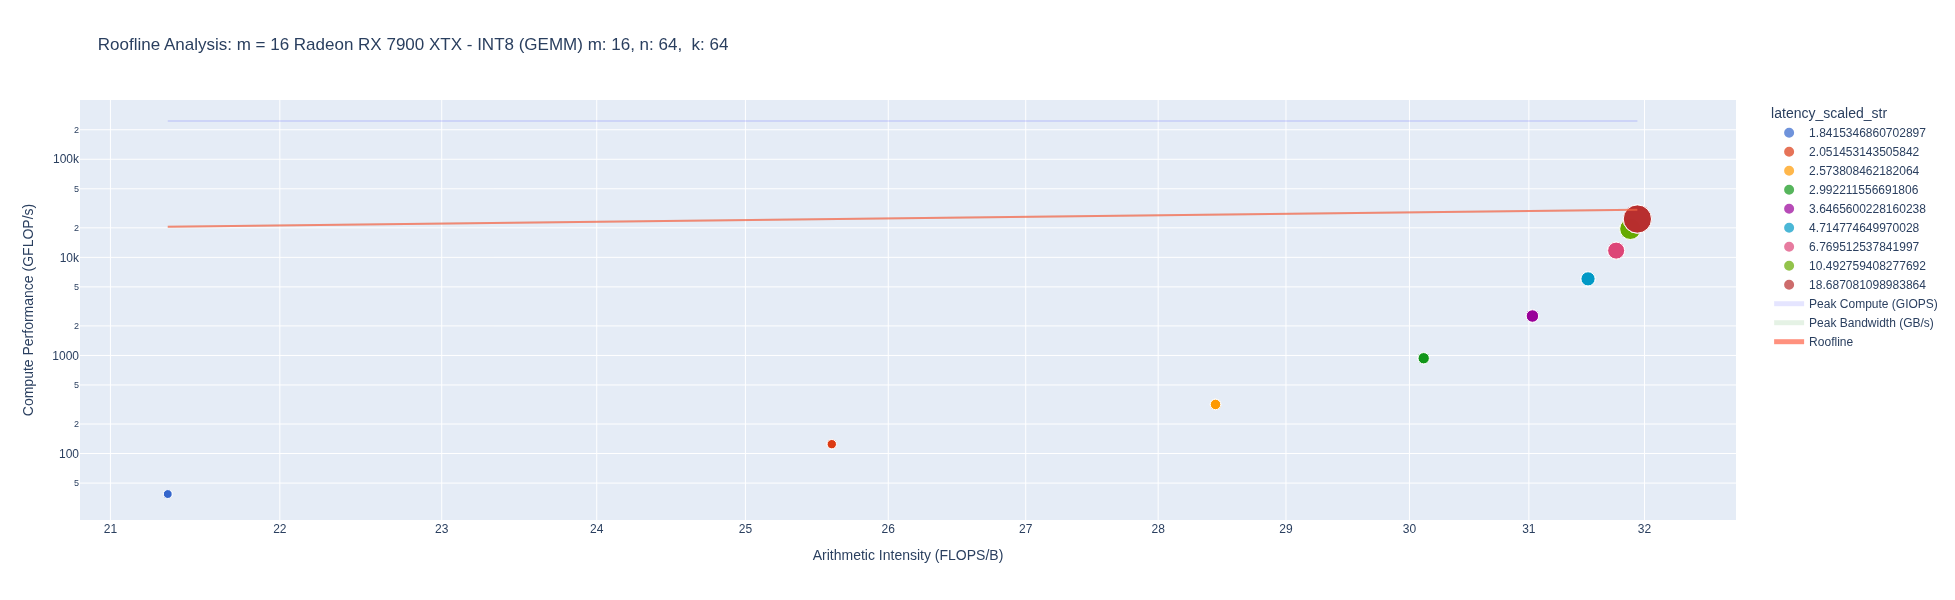

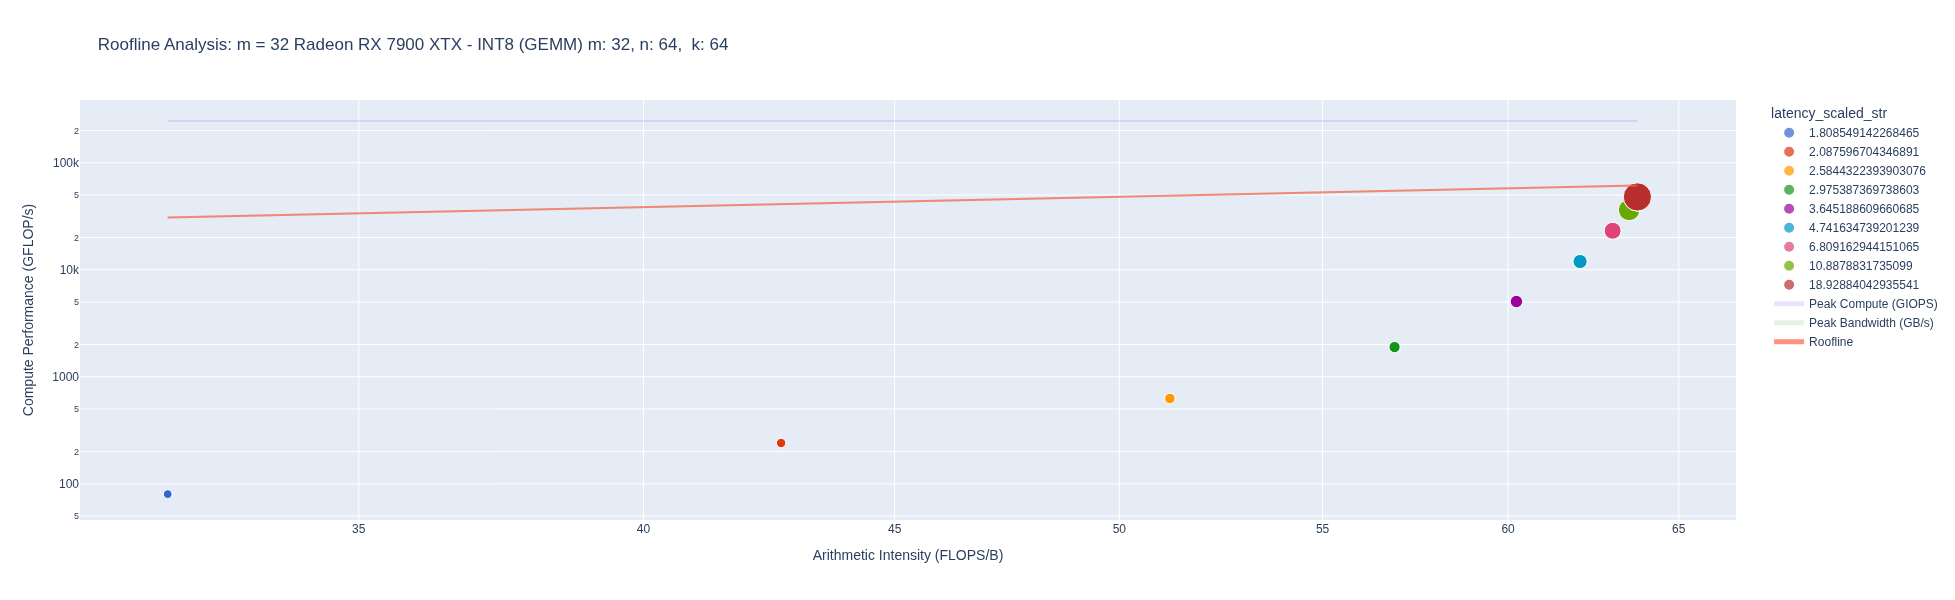

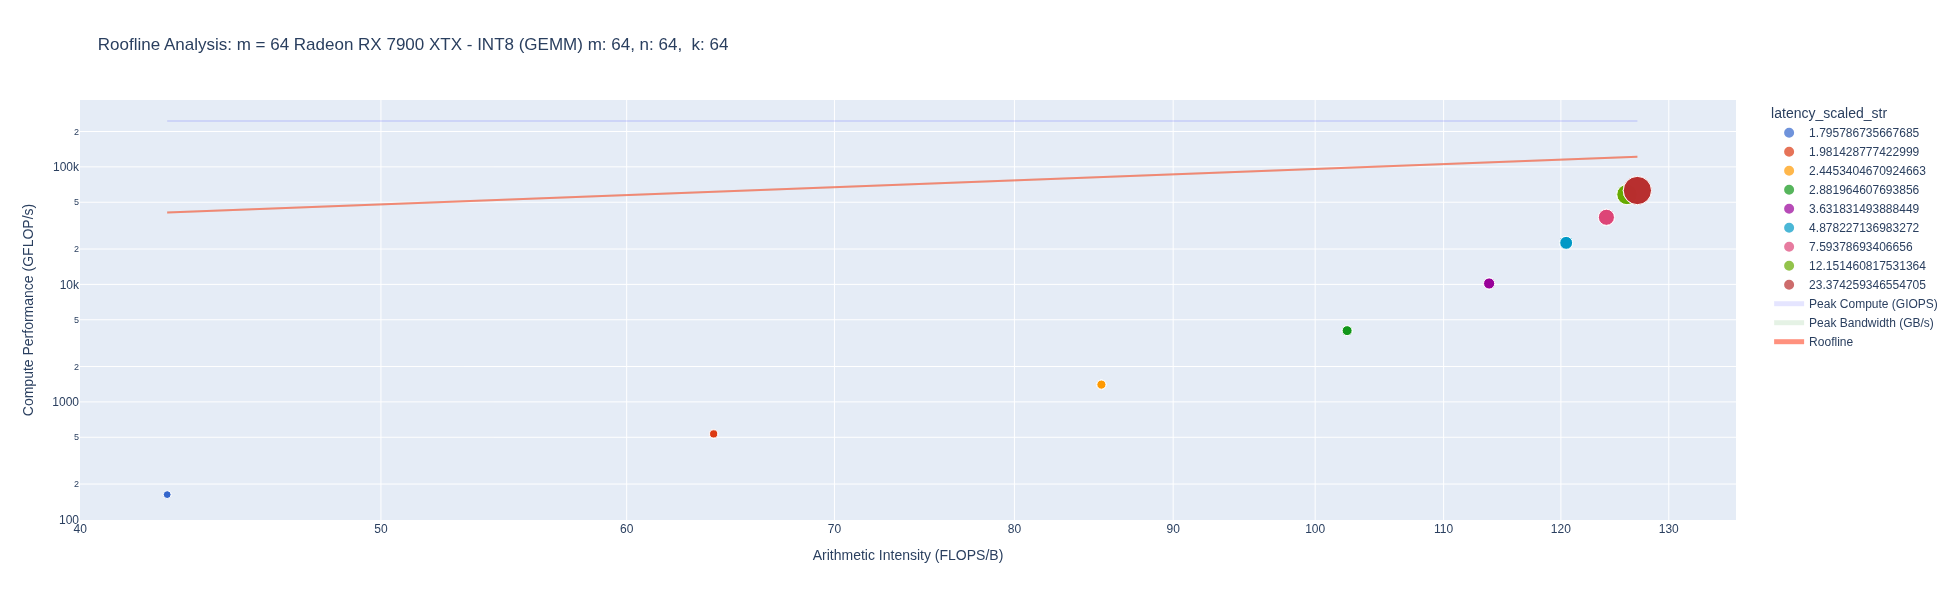

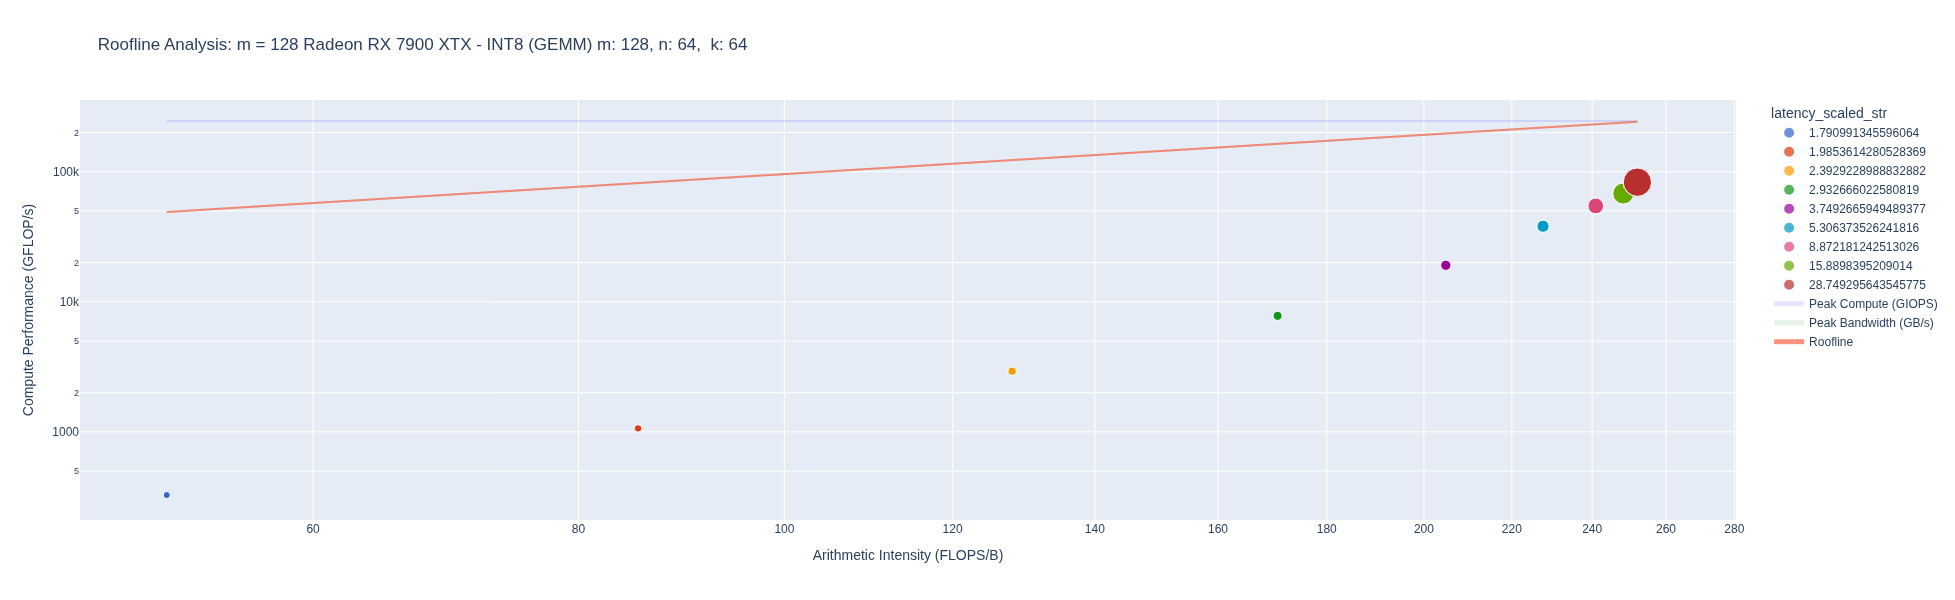

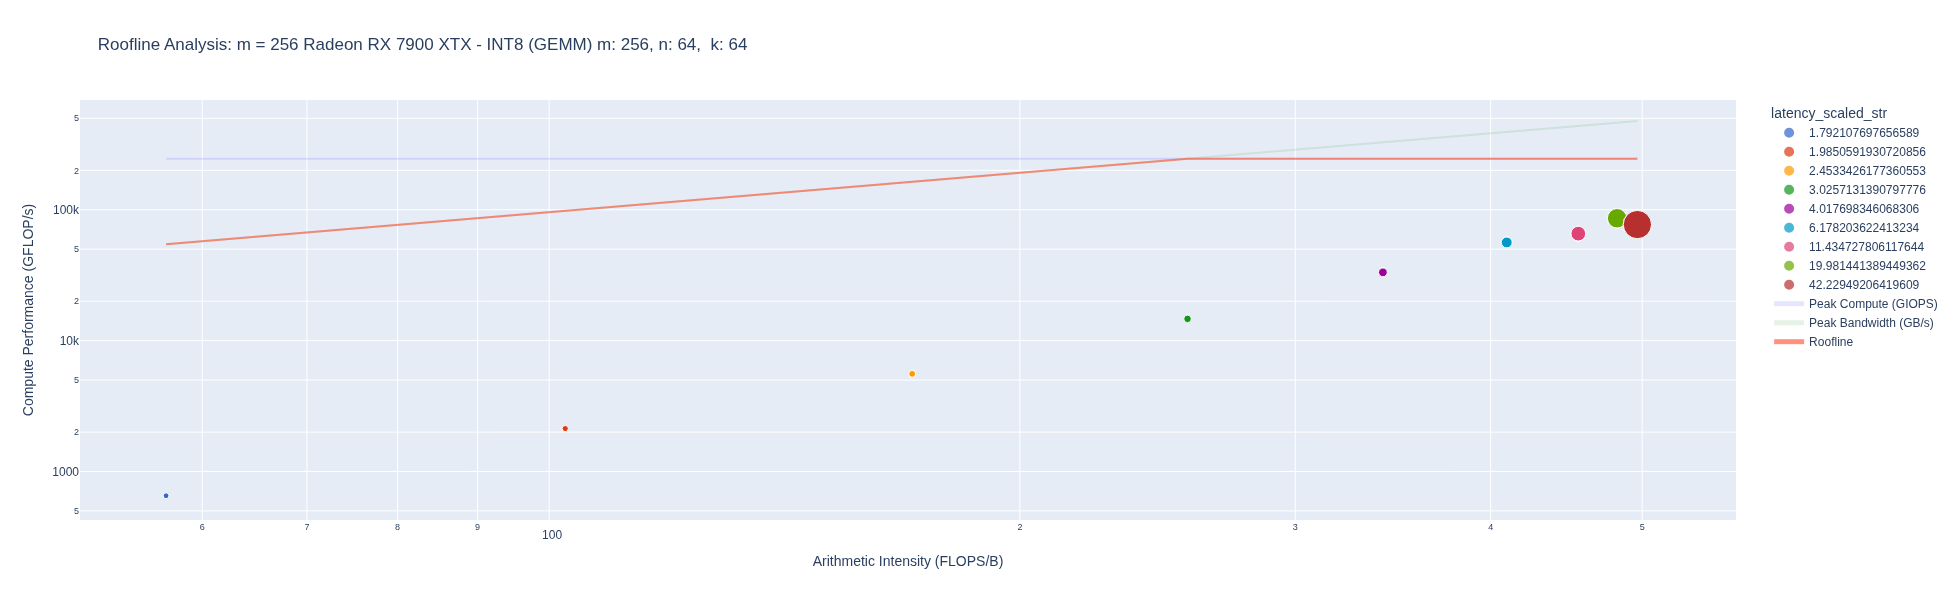

In [12]:
for d in figures:
    for _datatype, fig in d.items():
        fig.show()

## Advanced: Accessing the Roofline Data Directly

We can also access the raw data used to generate the roofline plots.

In [13]:
# Get the first result set for FLOAT16
result_set = results.get(DataType.FLOAT16.name, [])[0] if results else None

if result_set:
    # Calculate roofline data directly
    df = GemmPlotter.calculate_roofline_data(
        result_set=result_set
    )
    
    # Display the DataFrame
    display(df)
    
    # Show key metrics
    print(f"\nArithmetic Intensity Range: {df['arithmetic_intensity_value'].min()} to {df['arithmetic_intensity_value'].max()}")
    print(f"Performance Range (TFLOPS): {df['compute_performance_value'].min()} to {df['compute_performance_value'].max()}")
else:
    print("No results available to analyze")

shape: (44, 21)
┌─────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬─────────┬───────────┐
│ is_best ┆ latency_va ┆ latency_un ┆ memory_ban ┆ … ┆ memory_co ┆ memory_co ┆ group   ┆ attainabl │
│ ---     ┆ lue        ┆ it         ┆ dwidth_val ┆   ┆ nstraint_ ┆ nstraint_ ┆ ---     ┆ e_perform │
│ bool    ┆ ---        ┆ ---        ┆ ue         ┆   ┆ value     ┆ unit      ┆ str     ┆ ance_valu │
│         ┆ f64        ┆ str        ┆ ---        ┆   ┆ ---       ┆ ---       ┆         ┆ e         │
│         ┆            ┆            ┆ f64        ┆   ┆ f64       ┆ str       ┆         ┆ ---       │
│         ┆            ┆            ┆            ┆   ┆           ┆           ┆         ┆ f64       │
╞═════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═════════╪═══════════╡
│ false   ┆ 14.0521    ┆ μs         ┆ 0.601192   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 13.9165    ┆ μs         ┆ 0.607049   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 13.9997    ┆ μs         ┆ 0.603441   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 13.4309    ┆ μs         ┆ 0.628998   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 12.2881    ┆ μs         ┆ 0.687495   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ …       ┆ …          ┆ …          ┆ …          ┆ … ┆ …         ┆ …         ┆ …       ┆ …         │
│ false   ┆ 5.33964    ┆ μs         ┆ 1.58213    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 5.09644    ┆ μs         ┆ 1.65763    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 4.43563    ┆ μs         ┆ 1.90458    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 6.29844    ┆ μs         ┆ 1.34128    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ true    ┆ 3.42362    ┆ μs         ┆ 2.46756    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
└─────────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴─────────┴───────────┘


Arithmetic Intensity Range: 0.9696969696969697 to 0.9696969696969697
Performance Range (TFLOPS): 0.582974 to 2.39279


## Summary

In this notebook, we've demonstrated:

1. How to configure and run a GEMM scan with different matrix dimensions
2. How to generate roofline plots using the GemmPlotter class
3. How to access and analyze the raw roofline data